In [11]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import pygmt
import rf
import obspy
from math import ceil

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import Normalize



In [2]:
dataroot = "/g/data/ha3/am3591/analysis2"
network_dir = os.path.join(dataroot, "ALL-analysis")
try:
    run = os.environ['NB_ARGS']
except KeyError:
    print("Using latest run")
    run = max(
        [
            os.path.join(network_dir, d)
            for d in os.listdir(network_dir)
            if os.path.isdir(os.path.join(network_dir, d))
        ],
        key=os.path.getmtime,
    )
finally:
    run = os.path.join(network_dir, run)
stream = rf.read_rf(os.path.join(run, "rfstream.h5"), format='h5')
stacks = rf.read_rf(os.path.join(run, "rfstacks.h5"), format='h5').sort(["delay","network", "station"])

delays_df = pd.read_csv(os.path.join(run, "delays.txt"), names=("Network", "Station", "Longitude", "Latitude", "TPsb"), sep="\s+")
delays_df.set_index("Station", inplace=True)
delays_df.head()

<Axes: xlabel='TPsb', ylabel='Count'>

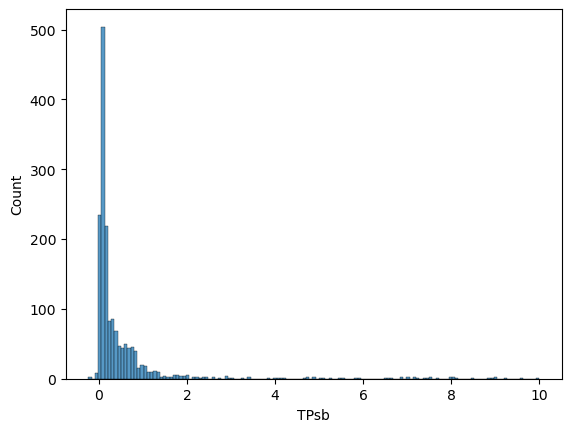

In [4]:
sns.histplot(data=delays_df, x="TPsb")

In [5]:
delays_df[delays_df["TPsb"] > 2]

Network  Longitude  Latitude  TPsb
Station                                   
TA06         7H   145.8263  -41.3820  2.92
E1E8         4H   144.9818  -32.6091  5.12
HPS15        8K   116.2871  -24.3146  7.50
NOMU         1G   124.5051   -9.5565  2.16
LEGO         1G   123.9533   -9.7124  8.06
...         ...        ...       ...   ...
AQTI6        1Q   144.7603  -26.6335  5.86
SQ1F1        8J   149.4719  -29.6388  4.14
SQ2G6        8J   148.3905  -30.1225  9.02
S2D2         7T   141.4421  -34.0869  4.64
BILLA        6K   136.4460  -29.9706  6.84

[71 rows x 4 columns]

In [6]:
delays_df[delays_df["TPsb"] < 0]

Network   Longitude   Latitude  TPsb
Station                                     
FA29         1K  125.410210 -31.180850 -0.06
RP06         7J  121.851400 -21.513300 -0.04
DPH          AU  130.842300 -12.466700 -0.04
BNA51        3M  107.548700  -6.817700 -0.08
EJA31        3M  113.143900  -7.768400 -0.06
ERM          II  143.157196  42.014999 -0.04
TL05         YS  125.659800  -8.985300 -0.06
WR03         7G  115.374000 -24.407800 -0.22
AQ3E4        4J  143.720700 -29.176800 -0.02
TL09         7I  134.764700 -25.682100 -0.24

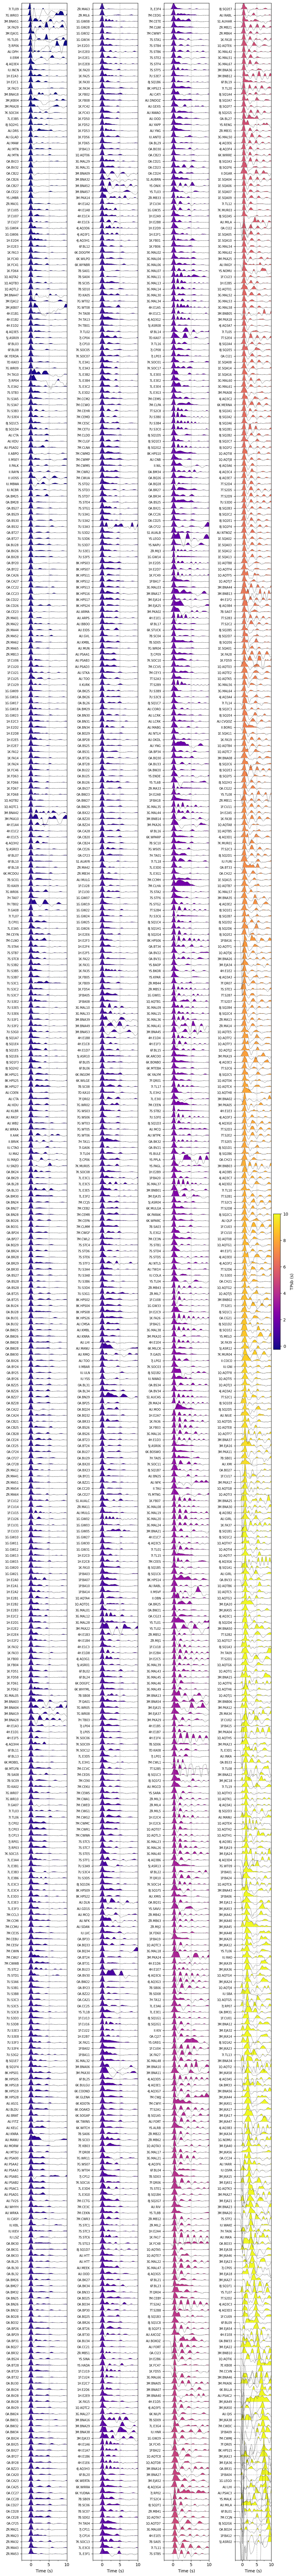

In [7]:
delays = [trace.stats.delay for trace in stacks]
norm = Normalize(vmin=min(delays), vmax=max(delays))
cmap = cm.plasma
nstacks = len(stacks)
ncols = 4
stacks_per_column = ceil(nstacks / ncols)

stack_height = 0.2
column_height = stack_height * stacks_per_column
fig, axs = plt.subplots(1, ncols, figsize=(10, column_height + 2), tight_layout=True)
for j, ax in enumerate(axs):
    i = 0
    column_stations = []
    while i < stacks_per_column:
        try:
            stack = stacks[j * stacks_per_column + i]
        except IndexError:
            # plot nothing so that what is plotted doesn't get stretched along y
            ax.plot(times, data + i, alpha=0)
            i += 1
            continue
        times = stack.times() - stack.stats.onset.second
        data = stack.data
        data /= data.max()
        level = stacks_per_column - 1 - i
        ax.fill_between(times, data + level, level, where=data>=0, fc=cmap(stack.stats.delay))
        ax.plot(times, data + level, "k", lw=0.3)
        column_stations.append(".".join([stack.meta.network, stack.meta.station]))
        i += 1
    while i:
        try:
            ax.set_yticks(np.arange(stacks_per_column - 1, stacks_per_column - 1 - i, -1), column_stations, fontsize="x-small", horizontalalignment="right")
        except ValueError:  # i != len(column_stations) 
            i -= 1
        else:
            break

for ax in axs:
    ax.xaxis.set_minor_locator(MultipleLocator(2.5))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.set_xlim([-2.5, 10])
    ax.set_ylim([-1, stacks_per_column])
    ax.grid(True, ls="--")
    ax.set_xlabel("Time (s)")

sm = cm.ScalarMappable(norm, cmap=cmap)
plt.colorbar(sm, label="TPsb (s)", ax=axs[-1])

In [8]:
events = {}
for tr in stream:
    m = tr.meta
    if m.event_id not in events:
        events[m.event_id.split("=")[-1]] = [m.event_longitude, m.event_latitude, m.event_depth, m.event_magnitude, m.distance]
events_df = pd.DataFrame(data=events, index=("Longitude", "Latitude", "Depth", "Magnitude", "Distance")).T
events_df.head()

Longitude  Latitude     Depth  Magnitude   Distance
603797971   128.4474    2.7153   56.1330       5.95  37.872504
603797981   145.1650   18.4629  531.0967       5.78  48.760136
603798180  -164.8659  -63.2650   10.0000       5.13  44.679278
603824898  -176.5188  -17.1613  370.1334       6.01  35.048825
603823975    96.8488    2.0171   21.5824       5.75  58.351435

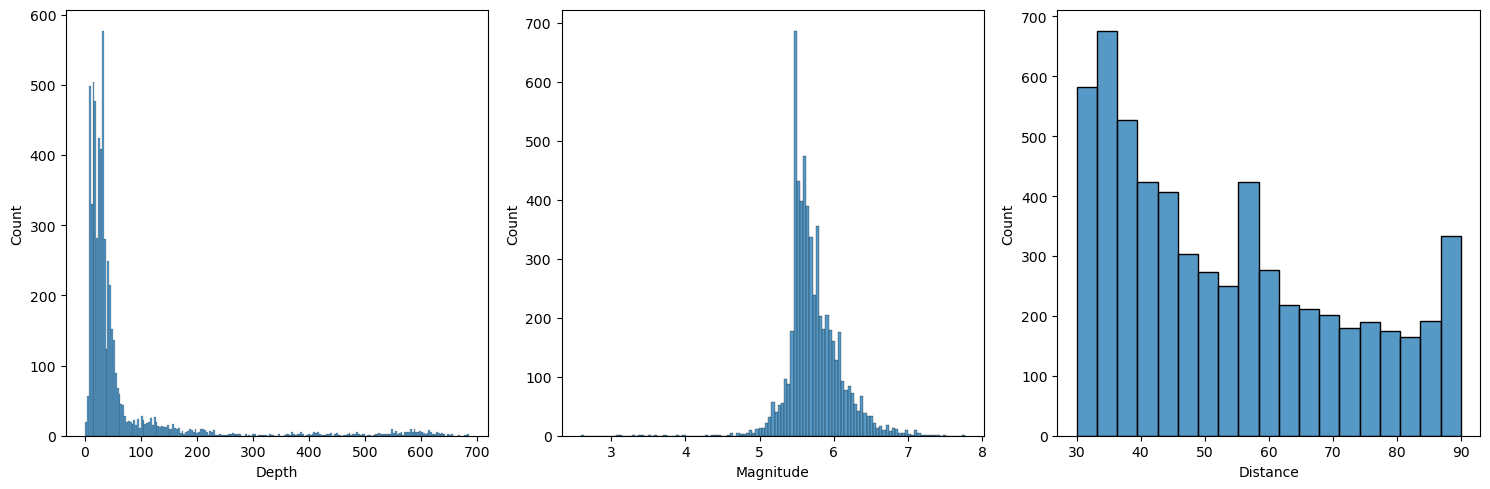

In [9]:
plot_these = ["Depth", "Magnitude", "Distance"]
fig, axs = plt.subplots(1, 3, figsize=(15,5), tight_layout=True)
for ax, d in zip(axs, plot_these):
    sns.histplot(data=events_df, x=d, ax=ax)
    ax.set_xlabel(d)

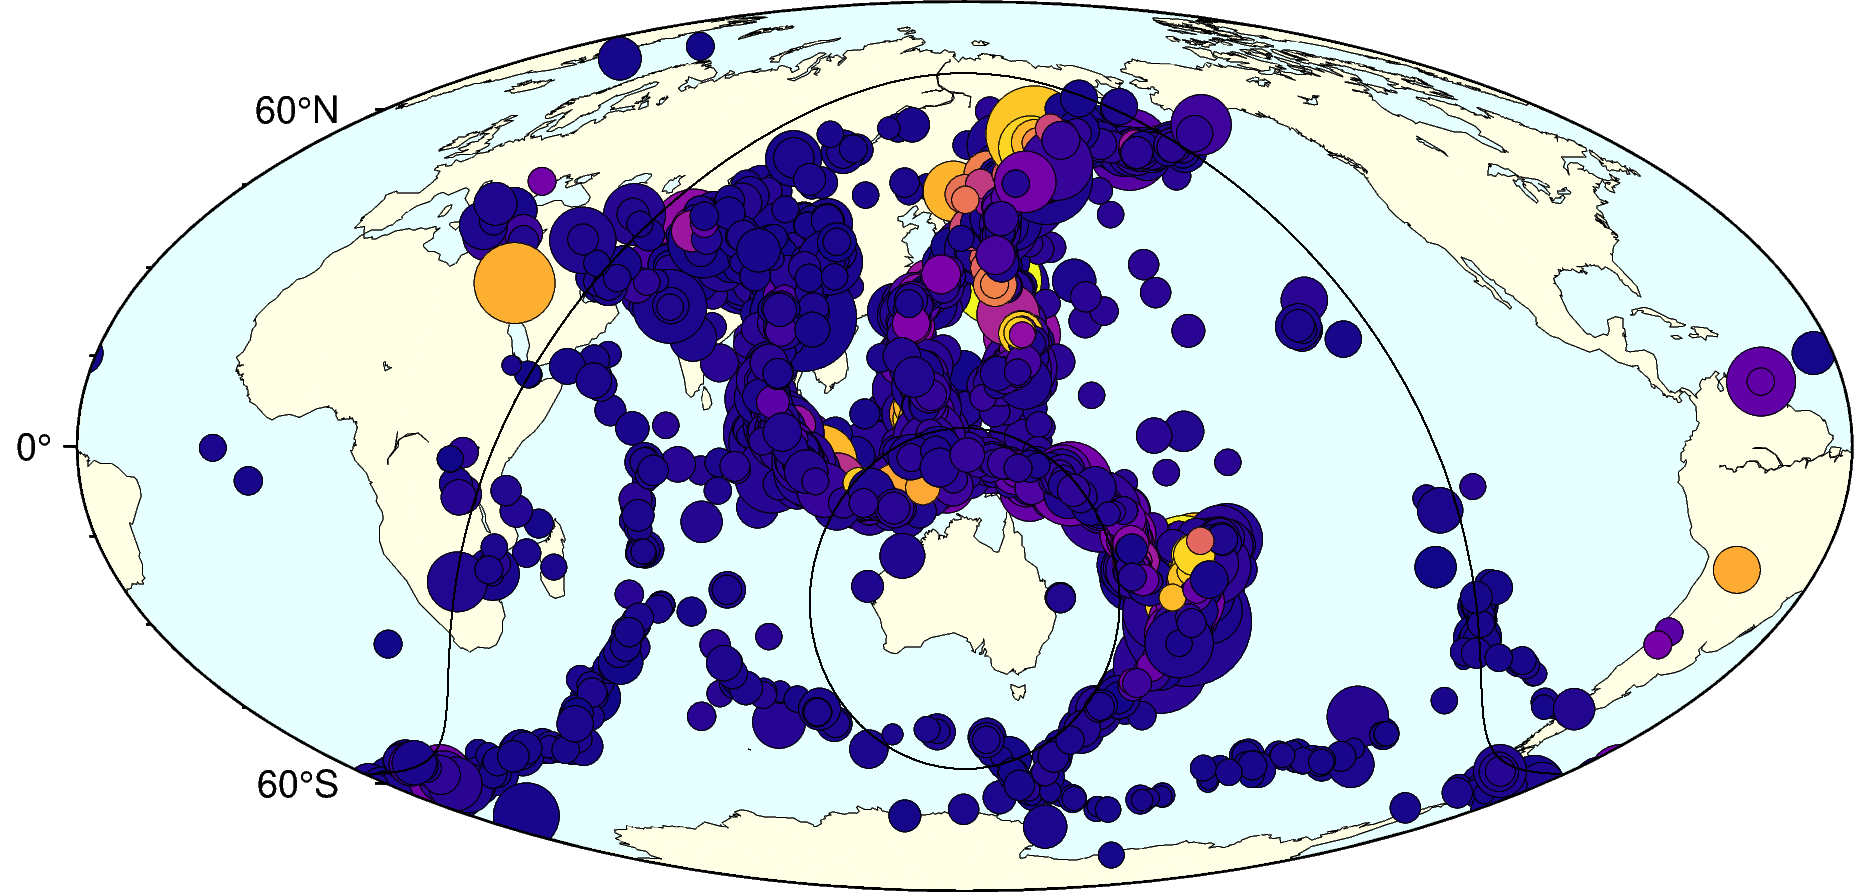

In [10]:
lon = (112 + 155) / 2
lat = (-46 + -8) / 2

region = "d"
projection = f"W{lon}/15c"
fig = pygmt.Figure()
fig.basemap(region=region, projection=projection)
fig.coast(
    region=region,
    projection=projection,
    area_thresh=10000,
    shorelines="0.1,black,solid",
    land="#ffffe6",
    water="#e6ffff",
)
pygmt.makecpt(cmap="plasma", series=[events_df.Depth.min(), events_df.Depth.max()])
fig.plot(
    region=region,
    projection=projection,
    x=events_df.Longitude,
    y=events_df.Latitude,
    size=0.005 * (2**events_df.Magnitude),
    style="cc",
    fill=events_df.Depth,
    cmap=True,
    pen="0.1p,black"
)
fig.plot(
    region=region,
    projection=projection,
    x=[lon] * 2,
    y=[lat] * 2,
    size=[30 *2, 95*2],
    style="E-d",
)

fig.show()
